In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
import os
import time
import random
import matplotlib.pyplot as plt  

from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
from skbio.diversity import alpha_diversity
from skbio.stats.distance import DistanceMatrix
from numpy import zeros
from skbio.stats.ordination import pcoa

import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import georasters as gr

import warnings
warnings.filterwarnings('ignore')

/home/zrimec/miniconda3/envs/plastics/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
# variables

e_cut = 1e-16
col = 'group_id'
corr_f = stats.spearmanr
palett = sns.color_palette("Paired",11)
label_hits = 'Num. plastic degrading enzymes'
label_plast = 'Num. degradable plastic types'
label_hits_n = 'Num. plastic\ndegrading enzymes'
label_plast_n = 'Num. degradable\nplastic types'

# plastics as additional
additives = ['PA','phthalate','DBP','TP']
plastic_order=['PET','PHB','PLA','PBAT',
                'PU','PS','PVA','PE',
                'PBS','PHA','Nylon','PEG','PHO',
                'TP','phthalate','DBP','PA']

env_old = ['Savannas',      
 'Dry_tropical_forests',
 'Moist_tropical_forests', 
 'Tropical_montane_forests',
 'Mediterrean',
 'Grasslands_and_shrublands',
 'Southern_temperate_forests',
 'Temperate_coniferous_forests',
 'Temperate_deciduous_forests',
 'Boreal_forests',
 'Arctic_tundra']

env_order = ['Savannas ',      
 'Dry tropical forests',
 'Moist tropical forests', 
 'Tropical montane forests',
 'Mediterranean ',
 'Grasslands and shrublands',
 'Southern temperate forests',
 'Temperate coniferous forests',
 'Temperate deciduous forests',
 'Boreal forests',
 'Arctic tundra']

dic_env = {env_old[i]: env_order[i] for i in range(len(env_order))}

dic_env2 = {'latitude': 'Latitude [°]',
 'longitude': 'Longitude [°]',
 'moisture': 'Moisture content [%]',
 'prec': 'Precipitation [L/m2]',
 'npp': 'NPP [g_C m−2 yr−1]',
 'pevapotrans': 'P. evapotrans. [L/m2]'}
dic_env2['conc_box_zscore'] = 'Exp. measured pollution'
dic_env2['num_hits'] = 'Num. hits'
dic_env2['pl_richness'] = 'Num. plastics'
dic_env2['carbon'] = 'Carbon [kg/m2]'
dic_env2['tmean'] = 'Temperature [°C]'

In [3]:
# functions
    
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = corr_f(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}, p = {p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)
    
def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# merge on closest value
# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

#http://readiab.org/book/latest/3/1
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    return numerator / denominator

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

def normalize(xx):
    mn = min(xx)
    mx = max(xx)
    return np.array([(x-mn)/(mx-mn) for x in xx])

# Load data

In [4]:
# soil metadata
df_soil_env = pd.read_csv('../data/df_soil_env.csv')
# merge soil_params
df_soil_env = df_soil_env.merge(pd.read_csv('../data/Soil_params.csv')
                                .rename(columns={'Unnamed: 0':'inscd_id'}),
                                on='inscd_id',how='left')
print(df_soil_env.shape)

# ena cross-mapping file
ena = pd.read_csv('../data/filereport_read_run_PRJEB18701_tsv.txt',sep='\t')
ena['filename'] = ena.submitted_ftp.apply(lambda x: x.split('/')[-1].split('.')[0])
print(ena.filename.unique().shape)
print(ena.sample_alias.unique().shape)

# fix filenames - remove 'R2_' and '_2 from Nrs and '_001' if 'old_' 
ena['filename'] = [x[:-2] if 'Nr' in x else x.replace('R2_','')[:-4] if 'old_' in x else x.replace('R2_','') for x in ena.filename]

(340, 26)
(288,)
(189,)


In [5]:
# load results
fdata = ['../data/soil_bork_parsed.csv',
         '../data/soil_australia_parsed.csv',
         '../data/soil_china_parsed.csv']
tmp = []
for f in fdata:
    tmp.append(pd.read_csv(f))
dfs = pd.concat(tmp)
print(dfs.shape)

# sanity check merging on filenames
print(dfs[dfs.dataset=='soil_bork']
                                               .target_name
                                               .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x 
                                                      else '_'.join(x.split('_')[:5]))
                                              .unique()
      .shape
     )
print(all(pd.Series(dfs[dfs.dataset=='soil_bork']
                                               .target_name
                                               .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x 
                                                      else '_'.join(x.split('_')[:5]))
                                              .unique().tolist()
         ).isin(ena.filename.unique().tolist())
))

dfs.at[dfs.dataset=='soil_bork','filename'] = (dfs[dfs.dataset=='soil_bork']
                                               .target_name
                                               .apply(lambda x: '_'.join(x.split('_')[:2]) if 'Nr' in x 
                                                      else '_'.join(x.split('_')[:5]))
                                              )

# store
dfs['id_other'] = dfs.id
dfs.drop(columns=['id'],inplace=True)

# merge bork data
dfs = (dfs.merge(ena[['filename','run_accession']]
                 .rename(columns={'run_accession':'run'}),
                on='filename',how='left')
      )
print(dfs.shape)

# other datasets
dfs.at[dfs.dataset=='soil_australia','run'] = (dfs[dfs.dataset=='soil_australia']
                                               .target_name
                                               .apply(lambda x: x.split('_')[0])
                                              )
dfs.at[dfs.dataset=='soil_china','run'] = (dfs[dfs.dataset=='soil_china']
                                               .target_name
                                               .apply(lambda x: x.split('_')[0])
                                              )

# merge
dfs = dfs.merge(df_soil_env[['run','latitude','longitude','country','environment']],
                on='run',how='left')
print(dfs.shape)

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives),'additive'] = True
dfs['group_id'] = dfs.run

# cleanup
dfs = (dfs
        .drop(columns=['target_id','label','filename'])
      .rename(columns={
#                         'lats':'latitude',
#                        'lons':'longitude',
                       'e-value':'e_value'})
      )
print(dfs.shape)

# rename some countries
dic = {'Viet Nam':'Vietnam',
 'Democratic Republic of the Congo':'Democratic Republic of Congo',
 'USA':'United States'}
dfa = dfs.replace({'country':dic})

(18279, 22)
(262,)
True
(18279, 24)
(18279, 28)
(18279, 27)


# Analysis

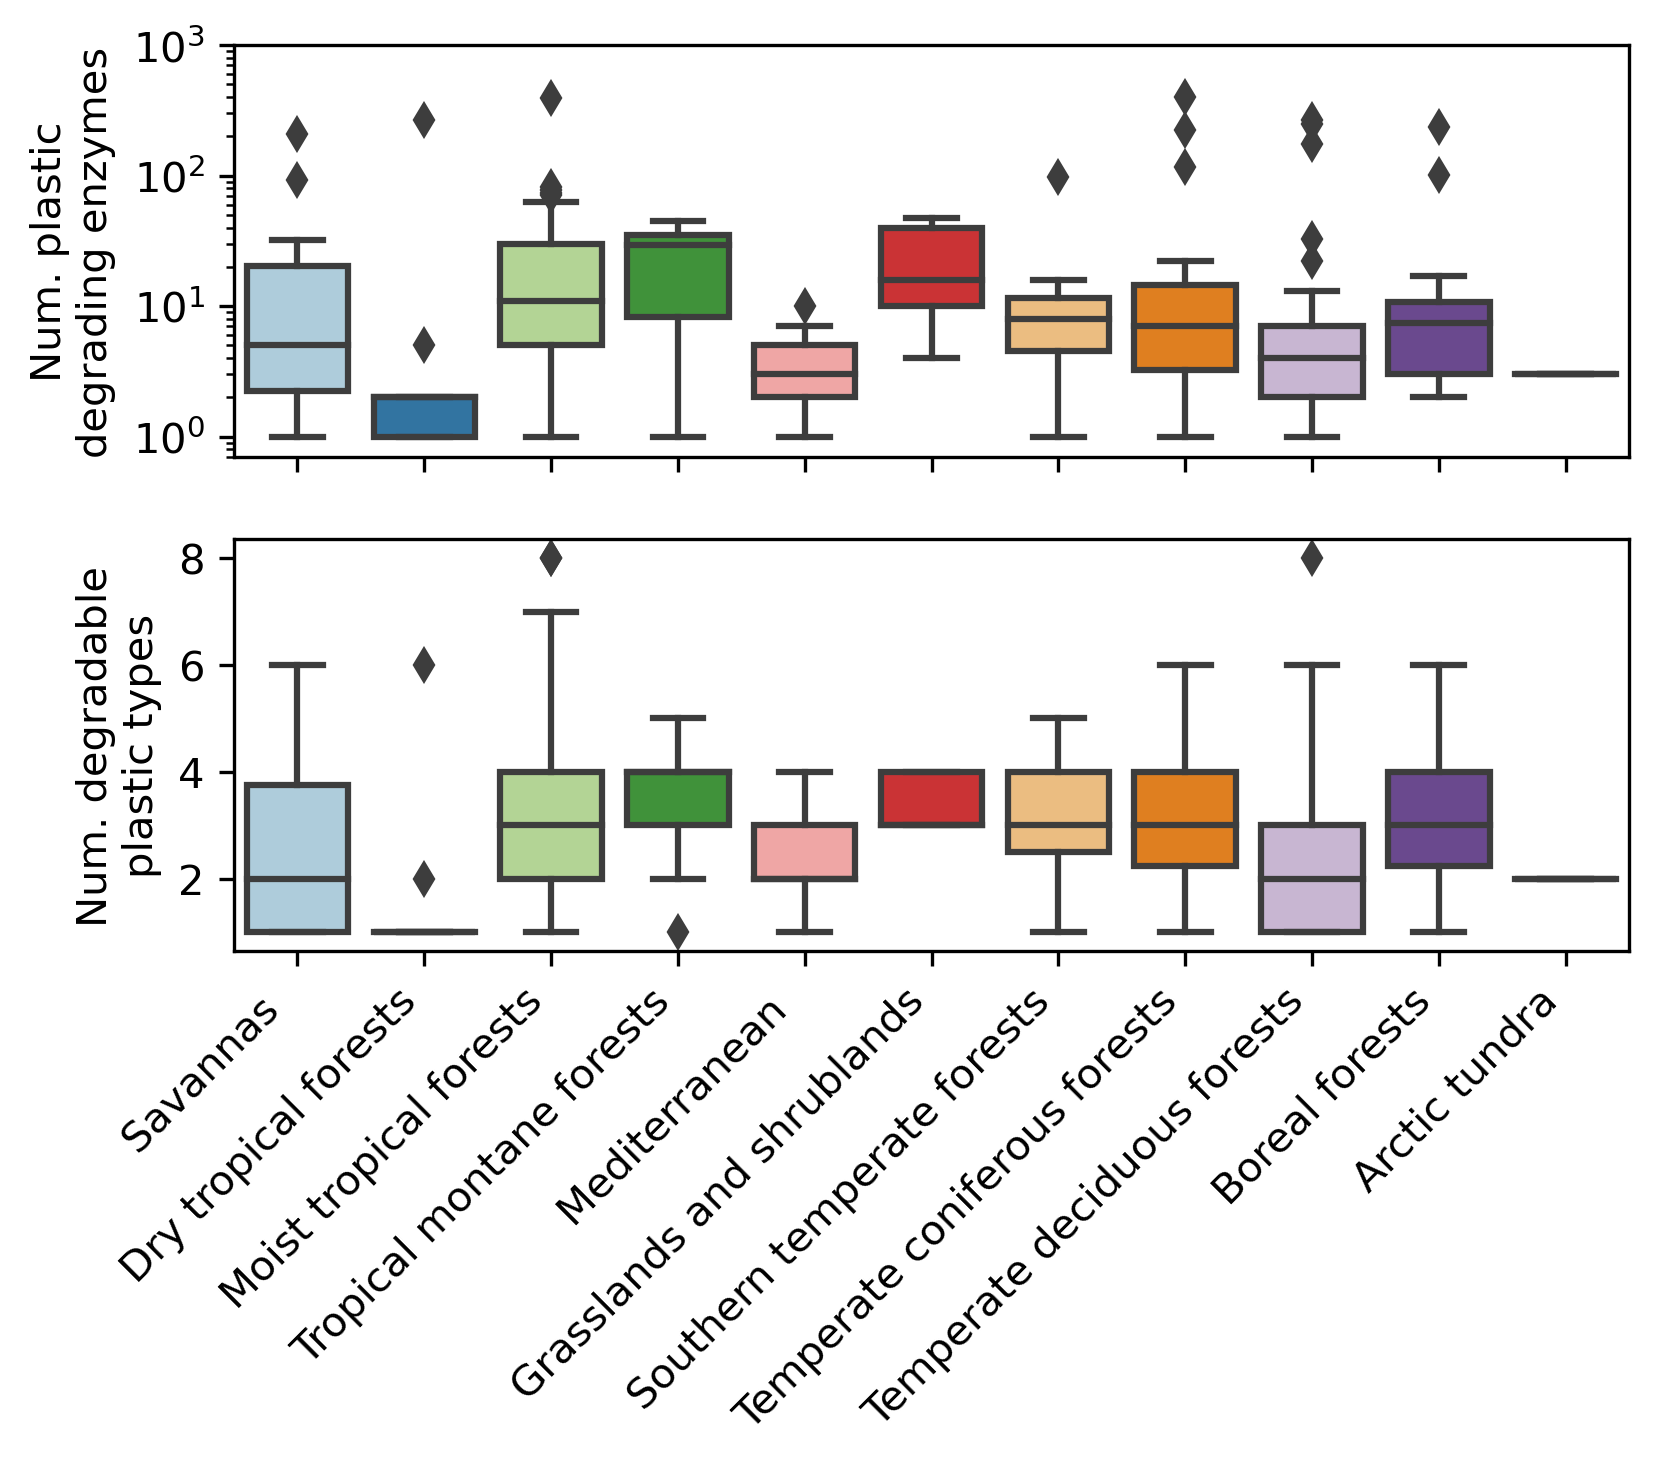

In [6]:
# per soil habitat - separate plots
# average per sampling site and variability
# make long df and use facet grid
col2 = 'environment'
dfs = (dfa
       .query('e_value<=@e_cut')
       .query("dataset=='soil_bork'")
        .replace({'environment':dic_env})
      )

tmp = []
tmp.append(dfs.groupby([col2,col]).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs.groupby([col2,col]).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs.groupby([col2,col]).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# via subplots
mpl.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(2,figsize=(6,4))

k=0
for what in ['Num. hits','Num. plast.']:
    sns.boxplot(data=pd.concat(tmp).query('ylabel==@what'),
            x=col2,y='value',
                order=env_order,
                ax=axs[k],
                palette=palett
               )
    if what == 'Num. hits':
        axs[k].set_ylabel(label_hits_n)
    else:
        axs[k].set_ylabel(label_plast_n)
    k+=1
    
axs[-1].get_shared_x_axes().join(*axs)
[axs[k].set_xticklabels([]) for k in range(1)]
[axs[k].set_xlabel('') for k in range(1)]
plt.xticks(rotation=45,ha='right')
plt.xlabel('')
axs[0].set_yscale('log')
axs[0].set_ylim([0.7,1000])
axs[0].set_yticks([1,10,100,1000])
#axs[0].set_title('Soil')
plt.show()

In [7]:
dfs.groupby('environment').group_id.nunique()

environment
Arctic tundra                    1
Boreal forests                  14
Dry tropical forests             9
Grasslands and shrublands        5
Mediterranean                   13
Moist tropical forests          88
Savannas                        14
Southern temperate forests      23
Temperate coniferous forests    18
Temperate deciduous forests     42
Tropical montane forests        34
Name: group_id, dtype: int64

In [8]:
# all vs the rest significance test
test = stats.ranksums
what = 'Num. hits'
data = pd.concat(tmp).query('ylabel==@what')
data

ranksum = []
for var in data.environment.unique():
    r,p = test(data.query('environment==@var').value,
         data.query('environment!=@var').value
        )
    n = data.query('environment==@var').shape[0]
    ranksum.append([var,p,n])
pd.DataFrame(ranksum,columns=['environment','p','n'])

,environment,p,n
0,Arctic tundra,0.381038,1
1,Boreal forests,0.941975,14
2,Dry tropical forests,0.003540,9
3,Grasslands and shrublands,0.159803,5
4,Mediterranean,0.001758,13
5,Moist tropical forests,0.004733,88
6,Savannas,0.503083,14
7,Southern temperate forests,0.775705,23
8,Temperate coniferous forests,0.947110,18
9,Temperate deciduous forests,0.000463,42


In [9]:
# stats for text
print(dfa.query('e_value<=@e_cut')
      .drop_duplicates(subset=['latitude','longitude'])
      .groupby('dataset').target_name.count())
print(dfs.country.nunique())
print(dfs.environment.nunique())

dataset
soil_australia      5
soil_bork         163
soil_china          1
Name: target_name, dtype: int64
38
11


# Correlation analysis

In [10]:
df_rich = (dfs
   .groupby(col)
    .target_name.count()
    .rename('num_hits')
    .reset_index()
)
df_rich['pl_richness'] = (dfs
   .groupby(col)
   .plastic.nunique()
   .values
)
df_rich['hmm_richness'] = (dfs
   .groupby(col)
   .hmm_model.nunique()
   .values
)
# concat
df_rich = df_rich.merge(dfs[[col,'country']].drop_duplicates(),
                        on=col,how='left')
df_rich.head()

,group_id,num_hits,pl_richness,hmm_richness,country
0,ERR1877650,3,2,3,Mexico
1,ERR1877651,10,3,9,Sri Lanka
2,ERR1877652,3,2,2,Finland
3,ERR1877653,13,3,8,Russia
4,ERR1877654,4,3,4,Colombia


### Environmental variables

In [11]:
# merge
data = (df_rich
 .merge(df_soil_env
        ,on=col,how='left')
)
df_soil_env.columns

# correlatons
x = ['num_hits','pl_richness']
y = ['carbon','environment','latitude','longitude', 
     'moisture','npp','pevapotrans','ph', 
     'prec','tmax','tmin','tmean',
    'pH', 'Ca', 'Mg', 'P', 'K', 'C', 'N']

df_pcc = []
for colx in x:
    for coly in y:
        tmp1 = data[[colx,coly]].dropna()
        tmp2 = corr_f(tmp1[colx],tmp1[coly])
        df_pcc.append([colx,coly,tmp2[0],tmp2[1],tmp1.shape[0]])
        
df_pcc = (pd
          .DataFrame(df_pcc,columns=['x','y','r','p','n'])
          .query('p<1e-4')
          .query('x.isin(["num_hits","pl_richness"])')
          .sort_values(by='r',ascending=False)
         )
df_pcc

,x,y,r,p,n
5,num_hits,npp,0.417015,1.394718e-10,218
3,num_hits,longitude,0.331893,3.959860e-08,261
8,num_hits,prec,0.330465,4.562058e-08,261
24,pl_richness,npp,0.306956,3.873127e-06,218
4,num_hits,moisture,0.292393,6.820866e-06,229
6,num_hits,pevapotrans,0.258215,7.706040e-05,229
22,pl_richness,longitude,0.248481,4.930342e-05,261


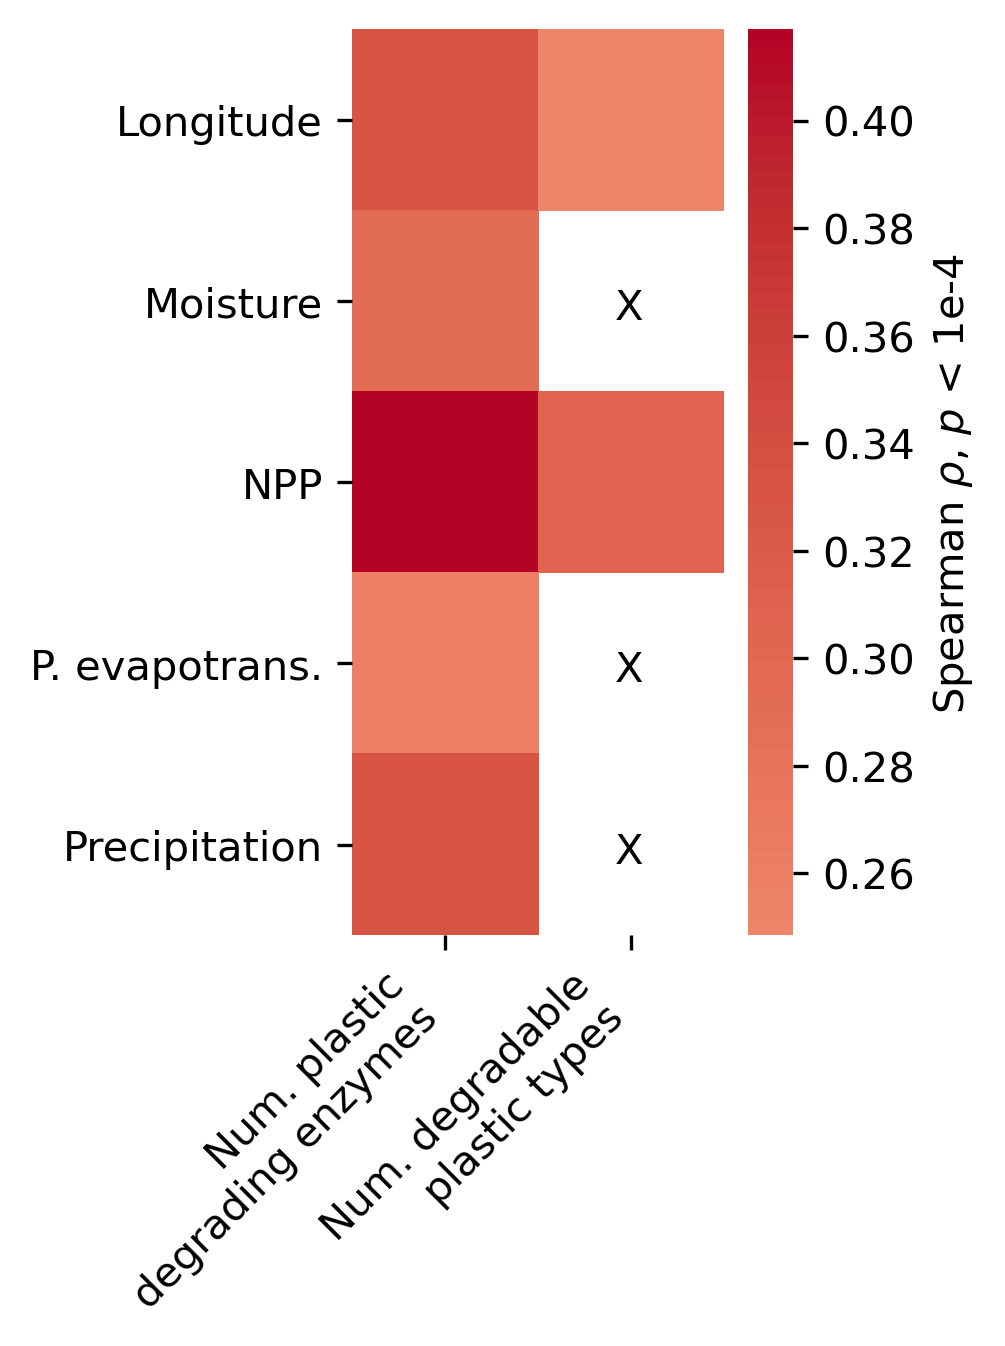

In [12]:
# plot this heatmap
dic_tmp = {'Npp':'NPP',
         'Pevapotrans':'P. evapotrans.',
         'Prec':'Precipitation'}
dic_x = {'num_hits':label_hits_n,
         'pl_richness':label_plast_n
        }

# get data to df 
df_pcc['y']=df_pcc.y.str.capitalize()
data = (df_pcc
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .replace({'y':dic_tmp})
        .pivot(index='x',columns='y',values='r')
        .transpose()
       )
data

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,4))
sns.heatmap(data[[label_hits_n,label_plast_n]],
            cmap='coolwarm',center=0,
           cbar_kws={'label': "Spearman "+r'$\rho$, $p$ < 1e-4',
                    })
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0,ha='right')
#plt.title('Soil, $p$ < 1e-4')

# plot xs for variables that are not below p-val cutoff
plt.annotate('X',xy=(1.41,1.6))
plt.annotate('X',xy=(1.41,3.6))
plt.annotate('X',xy=(1.41,4.6))

plt.show()

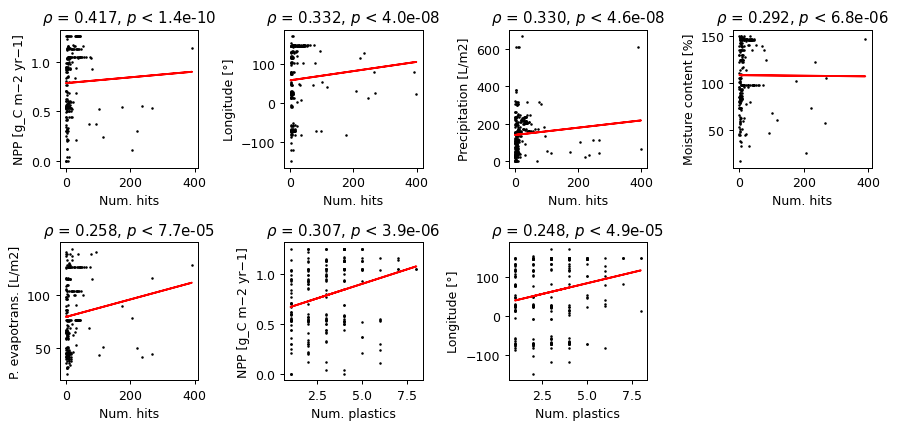

In [13]:
# Plot all correlations subplot
dic_x = {'num_hits': 'Num. hits',
         'pl_richness': 'Num. plastics'
        }

data = (df_rich
 .merge(df_soil_env
        ,on=col,how='left')
)
df_pcc['y']=df_pcc.y.str.lower()
tmp = (df_pcc        
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .sort_values(by='x')
)
tmp

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,6.8))
k=1
for idx,row in tmp.iterrows():
    
    plt.subplot(3,4,k)
    var1 = df_pcc.loc[idx].x
    var2 = df_pcc.loc[idx].y
    x = data[[var1,var2]].dropna()[var1] 
    y = data[[var1,var2]].dropna()[var2]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, slope*x+intercept, 'r', label='fitted line')
    plt.xlabel(row.x)
    plt.ylabel(dic_env2[var2])
    plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
              ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
    k+=1
    
plt.tight_layout()
plt.show()

## Pollution data

In [14]:
def get_pcc(itr,corr_f=corr_f,col=col):
    d = itr[2]
    tmp = (itr[-1][itr[-1].dataset.isin(itr[3])]
           .query('dist<=@d')
          )
    r,p = corr_f(tmp[itr[0]],tmp[itr[1]])
    return itr[0],itr[1],itr[2],len(itr[3]),r,p,tmp[col].unique().shape[0],itr[3]

# load
pol_soil = pd.read_csv('../data/inadequately-managed-plastic.csv',
                       names=['country','code','year','conc'],skiprows=1)
pol_soil['measure'] = pd.read_csv('../data/inadequately-managed-plastic.csv',
                                  names=['country','code','year','conc']).conc.iloc[0]
pol_soil['dataset'] = 'inadequately-managed-plastic'
a,_ = stats.boxcox([x+1 for x in normalize(pol_soil.conc.values)])
pol_soil['conc_box_zscore'] = a
print(pol_soil.year.unique())
print(pol_soil.country.count())

# correlations
data = (pol_soil.merge(df_rich[['num_hits','country',col]],
                         on='country',
                         how='right').dropna()
.merge(df_soil_env[[col,'environment']].drop_duplicates(),
             on=col,how='left')
       )

dists = [1]
data['dist'] = 0 #dummy variable
pars = [['conc_box_zscore',
         'num_hits',d,
         ['inadequately-managed-plastic'],
         data] for d in dists]
pcc = (pd.DataFrame(list(map(get_pcc,pars)),
                   columns=['var1','var2','dist','num_dsets','r','p','n','dsets'])
       .query('p<0.05')
       .sort_values(by='r',ascending=False)
       .query('var1=="conc_box_zscore"')
       .drop_duplicates(subset='var2')
      )

[2010]
186


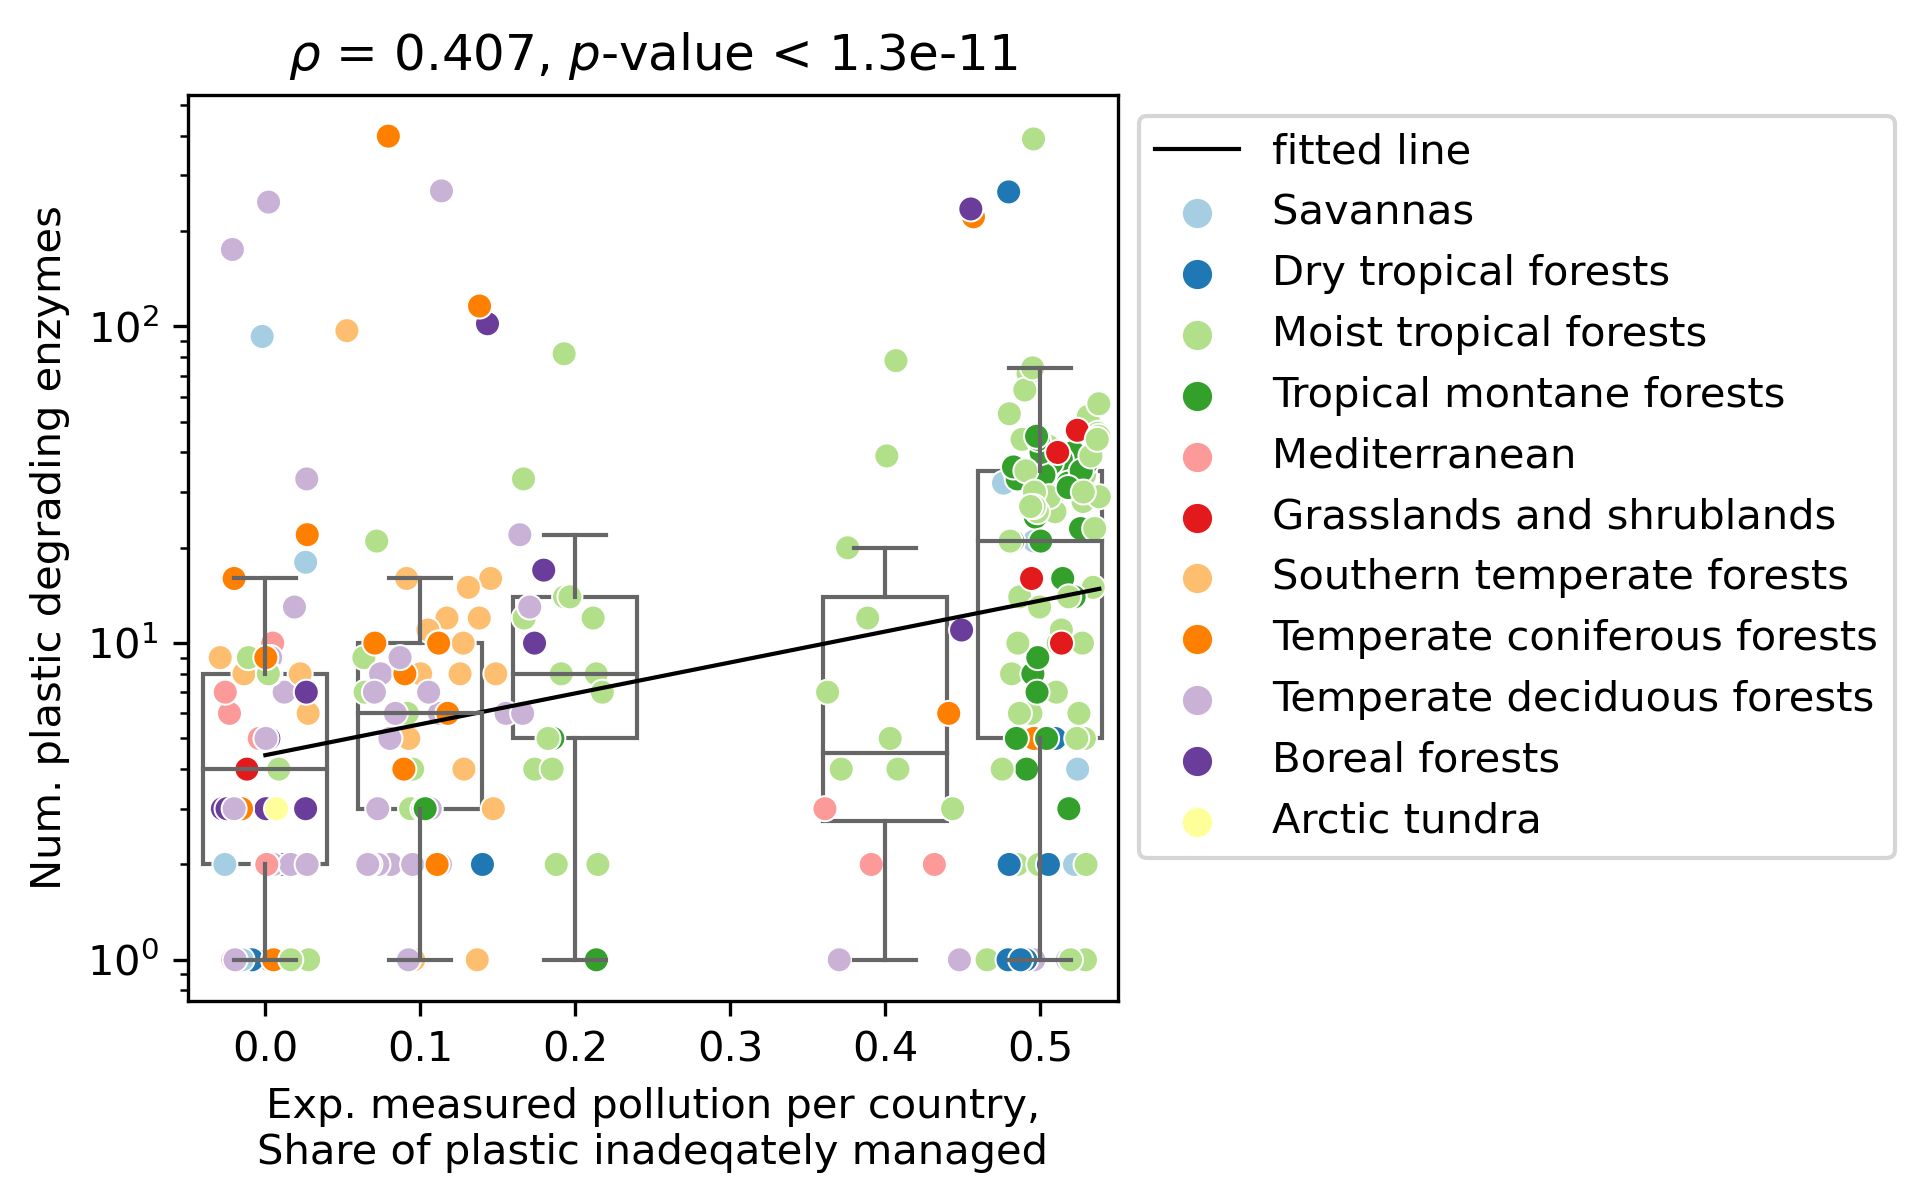

In [15]:
# plot
random.seed(1234)

# distribution of enzyme-hits for strata of pollution level
# rescaling numerical data for plot, scale is x*10-1
x = data['conc_box_zscore'].apply(lambda x: x*10).values
y = data['num_hits'].values
env = data['environment'].values
cor = corr_f(x,y)
x2 = np.round(x)/10
x2 = np.append(x2,0.3) # add empty 0.3 value

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,4))

x = [xx+random.uniform(-0.3, 0.3) for xx in x]
ax = sns.scatterplot(data=(pd
                           .DataFrame([x,y,env])
                           .transpose()
                           .rename(columns={0:'x',1:'y',2:'environment'})
                           .replace({'environment':dic_env})
                          ),
                    x='x',y='y',#color='k',
                    hue='environment',
                    hue_order=env_order,
                    palette=palett
                    )

ax = sns.boxplot(data=pd.DataFrame([x2,y]).transpose().rename(columns={0:'x',1:'y'}),
           x='x',y='y',color='white',#orient='h',
           fliersize=0)
plt.setp(ax.artists, edgecolor = '.4', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='.4', linewidth=1)

# # line fit semi-log scale
p1 = np.polyfit(x, y, 1)
p1 = stats.siegelslopes(y, x, method='hierarchical')
p2 = np.polyfit(x, y, 2)
plt.plot((0,max(x)), (p1[1],max(x)*p1[0]+p1[1]), 'k', linewidth=1, label='fitted line')

plt.xlabel('Exp. measured pollution per country,\nShare of plastic inadeqately managed')
plt.ylabel('Num. plastic degrading enzymes')
plt.title(r'$\rho$ = '+str("%.3f" % cor[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(cor[1])))
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

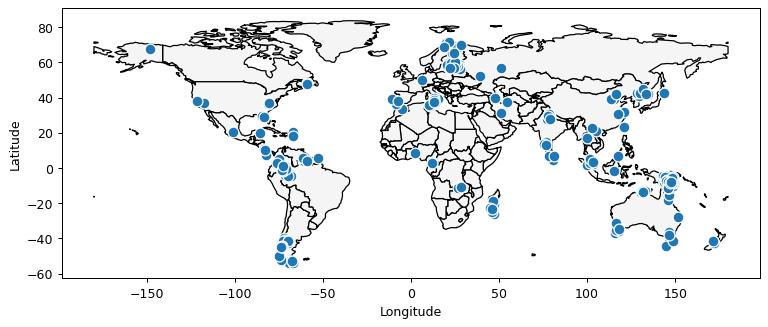

In [16]:
# plot analysed sampling locations on world map

random.seed(1111)
mpl.rcParams['figure.dpi'] = 90

# make geodf
df_plot = data.merge(df_soil_env[[col,'latitude','longitude']],
           on=col,how='left')
geometry = [Point((xy[0]+random.uniform(-2, 2),xy[1]+random.uniform(-2, 2))) 
            for xy in zip(df_plot['longitude'],df_plot['latitude'])]
geo_df = gpd.GeoDataFrame(df_plot[['dataset']],
                          geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

# plot
fig,ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax,color='whitesmoke', edgecolor='k')
geo_df.plot(ax=ax,marker='o',
            markersize=75,
            edgecolor='w')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

### Principal coordinate analysis

(84, 261)
PC1  PC1    0.138215
PC2  PC2    0.095519
dtype: float64


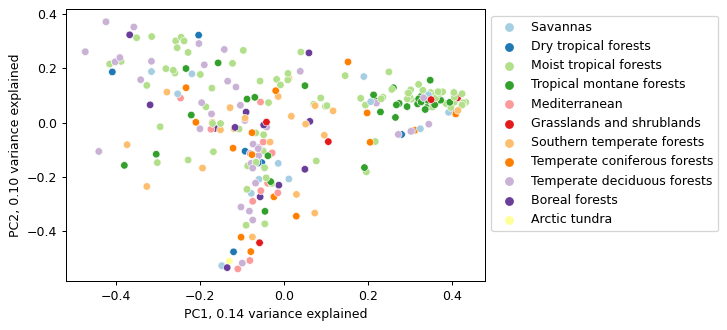

In [17]:
# BIOM table of hits per hmm_model vs samples
denom = (dfs
 .groupby(['hmm_model',col])
 .target_name.count()
 .rename('counts')
 .reset_index()
 .query('counts>0')
 .counts.min()
)

df_biom = (dfs
 .groupby(['hmm_model',col])
 .target_name.count()
 .rename('counts')
 .divide(denom)
 .round().astype(int)
 .unstack()
 .fillna(0)
)
print(df_biom.shape)

# distance matrix
bc_dm = table_to_distances(df_biom, bray_curtis_distance)

# perform pcoa
bc_dm_pc = pcoa(bc_dm)

# variance explained
tmp = bc_dm_pc.samples.cov()
tmp = pd.Series(np.diag(tmp), index=[tmp.index, tmp.columns])
sum(tmp/sum(tmp))
tmp = tmp/sum(tmp)
print(tmp[:2])

sns.scatterplot(data=bc_dm_pc.samples #gets df from pcoa
                .merge(df_soil_env
               .set_index(col)
               .loc[bc_dm_pc.samples.index,['environment']]
               .replace({'environment':dic_env}),
               left_index=True,right_index=True,
               how='left'),
                x='PC1',y='PC2',
                hue='environment',
                hue_order=env_order,
                palette=palett
               )
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('PC1, %.2f variance explained'%(tmp.iloc[0]))
plt.ylabel('PC2, %.2f variance explained'%(tmp.iloc[1]))
plt.show()

carbon SpearmanrResult(correlation=0.08983361603643478, pvalue=0.1698901596971601)
latitude SpearmanrResult(correlation=-0.22687697751402916, pvalue=0.00021899859259824346)
longitude SpearmanrResult(correlation=0.29619608367002126, pvalue=1.1048012231611864e-06)
moisture SpearmanrResult(correlation=0.15630059003586808, pvalue=0.017938790450204134)
npp SpearmanrResult(correlation=0.34318099149242104, pvalue=2.0301465299691387e-07)
pevapotrans SpearmanrResult(correlation=0.22791091318352213, pvalue=0.0005091375440283594)
ph SpearmanrResult(correlation=-0.008916497418197965, pvalue=0.8918519749563545)
prec SpearmanrResult(correlation=0.26925601762985124, pvalue=1.029821643284819e-05)
tmean SpearmanrResult(correlation=0.08498196439211513, pvalue=0.17105767753749462)
pH SpearmanrResult(correlation=-0.0972442469277304, pvalue=0.11706685781795861)
Ca SpearmanrResult(correlation=-0.04331288941844041, pvalue=0.4859845981869022)
Mg SpearmanrResult(correlation=-0.017927811688663607, pvalue=0.7731

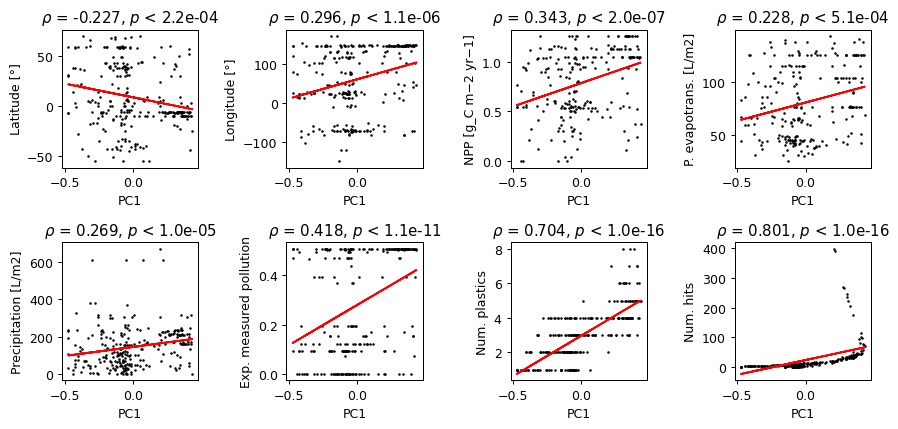

In [18]:
# check PC1 vs environment variables + pollution

col_env2 = ['carbon',
 'latitude',
 'longitude',
 'moisture',
 'npp',
 'pevapotrans',
 'ph',
 'prec',
 'tmean',
 'pH',
 'Ca',
 'Mg',
 'P',
 'K',
 'C',
 'N',
 'conc_box_zscore',
 'pl_richness',
 'num_hits']
 
data = (bc_dm_pc.samples
        .merge(df_soil_env
               .set_index(col)
               .loc[bc_dm_pc.samples.index],
               left_index=True,right_index=True,
               how='left')
        .reset_index().rename(columns={'index':col})
        .merge(df_rich[[col,'pl_richness','num_hits']],on=col,how='left')
        .merge(pol_soil[['country','conc_box_zscore']],
           on='country',how='left')
)
data

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,6.8))
k=1
for c in col_env2:
    x = data[['PC1',c]].dropna().PC1.values
    y = data[['PC1',c]].dropna()[c].values
    
    print(c, corr_f(x,y))
    
    if corr_f(x,y)[1] < 1e-1 and abs(corr_f(x,y)[0]) > 0.2:
        plt.subplot(3,4,k)
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
        plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
        plt.plot(x, slope*x+intercept, 'r', label='fitted line')
        plt.xlabel('PC1')
        plt.ylabel(dic_env2[c])
        plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
                  ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
        k+=1
    
plt.tight_layout()
plt.show()